## 1. Decision Trees

In [1]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def visualize_decision_tree(model, original_features, figsize=(20, 12), max_depth=4):
    """
    Visualize a DecisionTreeRegressor, whether inside a Pipeline or standalone.
    
    Parameters
    ----------
    model : Pipeline or DecisionTreeRegressor
    original_features : list[str]
        Columns provided to the model, including the genre column if present.
    """
    
    # -------------------------------------
    # 1. Model is a Pipeline
    # -------------------------------------
    if hasattr(model, "named_steps"):
        tree = model.named_steps["tree"]

        # If it has preprocessing
        if "preprocess" in model.named_steps:
            preprocess = model.named_steps["preprocess"]

            # Which columns were treated as categorical?
            if "cat" in preprocess.named_transformers_:
                # Extract OHE-expanded names
                ohe = preprocess.named_transformers_["cat"]
                categorical_original_col = preprocess.transformers_[0][2]  # list of categorical cols
                cat_features = ohe.get_feature_names_out(categorical_original_col)

                # Numeric features (other transformers)
                numeric_features = []
                for name, transformer, cols in preprocess.transformers_:
                    if name != "cat":
                        numeric_features.extend(cols)

                final_features = list(cat_features) + list(numeric_features)

            else:
                # No categorical transform
                final_features = original_features

        else:
            # Pipeline but no preprocessing
            final_features = original_features

    # -------------------------------------
    # 2. Raw DecisionTreeRegressor
    # -------------------------------------
    else:
        tree = model
        final_features = original_features

    # -------------------------------------
    # Final sanity check
    # -------------------------------------
    n_tree_features = tree.n_features_in_
    if len(final_features) != n_tree_features:
        print("Warning: feature name length mismatch!")
        print("Tree expects:", n_tree_features)
        print("Provided:", len(final_features))
        print("Adjusting to match tree input...")

        # Fix by truncating or padding
        if len(final_features) > n_tree_features:
            final_features = final_features[:n_tree_features]
        else:
            final_features = final_features + [f"feat_{i}" for i in range(n_tree_features - len(final_features))]

    # -------------------------------------
    # Plot
    # -------------------------------------
    plt.figure(figsize=figsize)
    plot_tree(
        tree,
        feature_names=final_features,
        filled=True,
        rounded=True,
        max_depth=max_depth,
        fontsize=10,
    )
    plt.show()


In [2]:
class VizNode:
    def __init__(self, feature=None, threshold=None, samples=None, value=None,
                 left=None, right=None, collapsed=False,
                 collapsed_next_feature=None, collapsed_next_threshold=None):
        self.feature = feature
        self.threshold = threshold
        self.samples = samples
        self.value = value

        self.left = left      # TRUE branch
        self.right = right    # FALSE branch (may be collapsed)

        self.collapsed = collapsed
        self.collapsed_next_feature = collapsed_next_feature
        self.collapsed_next_threshold = collapsed_next_threshold


def get_expanded_feature_names(model, raw_feature_names):
    # Pipeline?
    if hasattr(model, "named_steps"):
        preprocess = model.named_steps.get("preprocess", None)
        if preprocess is None:
            return raw_feature_names  # no preprocessing

        ohe = preprocess.named_transformers_["cat"]
        cat_cols = preprocess.transformers_[0][2]
        ohe_features = list(ohe.get_feature_names_out(cat_cols))

        # numeric columns:
        numeric_features = []
        for name, transformer, cols in preprocess.transformers_:
            if name != "cat":
                numeric_features.extend(cols)

        return ohe_features + numeric_features

    # Raw DecisionTreeRegressor
    return raw_feature_names


def build_viz_tree(tree, node_id, feature_names, depth=0, max_depth=None):
    """
    Convert sklearn tree to VizNode structure, with:
      - full expansion on TRUE branch
      - collapsed single-node on FALSE branch
      - safe recursion with max_depth cutoff
    """

    # ----- BOUNDS CHECK -----
    if node_id < 0 or node_id >= tree.node_count:
        return VizNode(collapsed=True, samples=0, value=0)

    left_id = tree.children_left[node_id]
    right_id = tree.children_right[node_id]

    # ----- LEAF CHECK (THE REAL WAY) -----
    is_leaf = (left_id == -1 and right_id == -1)

    # ----- MAX DEPTH STOP -----
    if max_depth is not None and depth >= max_depth:
        return VizNode(
            collapsed=True,
            samples=tree.n_node_samples[node_id],
            value=float(tree.value[node_id][0][0]),
            collapsed_next_feature=None,
            collapsed_next_threshold=None
        )

    # ----- LEAF NODE -----
    if is_leaf:
        return VizNode(
            feature=None,
            threshold=None,
            samples=tree.n_node_samples[node_id],
            value=float(tree.value[node_id][0][0]),
            left=None,
            right=None,
            collapsed=False
        )

    # ----- INTERNAL NODE -----
    feature_idx = tree.feature[node_id]
    threshold = tree.threshold[node_id]

    # ----- TRUE BRANCH (full recursion) -----
    left_node = build_viz_tree(
        tree, left_id, feature_names,
        depth=depth + 1,
        max_depth=max_depth
    )

    # ----- FALSE BRANCH (collapsed) -----
    if right_id != -1 and right_id < tree.node_count:
        r_left = tree.children_left[right_id]
        r_right = tree.children_right[right_id]

        # If the right subtree is NOT a leaf, extract next split
        if not (r_left == -1 and r_right == -1):
            next_feat = feature_names[tree.feature[right_id]]
            next_thresh = tree.threshold[right_id]
        else:
            next_feat = None
            next_thresh = None

        collapsed_samples = tree.n_node_samples[right_id]
        collapsed_value = float(tree.value[right_id][0][0])
    else:
        next_feat = None
        next_thresh = None
        collapsed_samples = 0
        collapsed_value = 0

    collapsed_node = VizNode(
        collapsed=True,
        samples=collapsed_samples,
        value=collapsed_value,
        collapsed_next_feature=next_feat,
        collapsed_next_threshold=next_thresh
    )

    return VizNode(
        feature=feature_names[feature_idx],
        threshold=threshold,
        samples=tree.n_node_samples[node_id],
        value=float(tree.value[node_id][0][0]),
        left=left_node,
        right=collapsed_node,
        collapsed=False
    )

import matplotlib.pyplot as plt

def draw_viz_tree(node, x=0, y=0, x_step=2.0, y_step=1.5, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.set_axis_off()

    # Build the text box
    if node.collapsed:
        text = (
            f"[COLLAPSED]\n"
            f"samples = {node.samples}\n"
            f"value = {node.value:.3f}\n"
            f"next split:\n"
            f"{node.collapsed_next_feature} <= {node.collapsed_next_threshold:.3f}"
            if node.collapsed_next_feature is not None else
            f"[COLLAPSED]\n"
            f"samples = {node.samples}\n"
            f"value = {node.value:.3f}"
        )
    elif node.feature is None:
        text = (
            f"[LEAF]\n"
            f"samples = {node.samples}\n"
            f"value = {node.value:.3f}"
        )
    else:
        text = (
            f"{node.feature} <= {node.threshold:.3f}\n"
            f"samples = {node.samples}\n"
            f"value = {node.value:.3f}"
        )

    ax.text(x, y, text, ha='center', va='center',
            bbox=dict(boxstyle="round", facecolor="#ffe0cc"))

    # Draw TRUE branch
    if node.left:
        ax.plot([x, x - x_step], [y - 0.1, y - y_step + 0.1], color='black')
        draw_viz_tree(node.left, x - x_step, y - y_step, x_step*0.9, y_step, ax=ax)

    # Draw FALSE branch (collapsed)
    if node.right:
        ax.plot([x, x + x_step], [y - 0.1, y - y_step + 0.1], color='black')
        draw_viz_tree(node.right, x + x_step, y - y_step, x_step*0.9, y_step, ax=ax)

    return ax

def plot_condensed_tree(model, raw_feature_names, max_depth=6):
    expanded_names = get_expanded_feature_names(model, raw_feature_names)

    if hasattr(model, "named_steps"):
        tree = model.named_steps["tree"].tree_
    else:
        tree = model.tree_

    viz_root = build_viz_tree(
        tree, node_id=0,
        feature_names=expanded_names,
        depth=0,
        max_depth=max_depth
    )

    ax = draw_viz_tree(viz_root)
    plt.show()



R²: 0.02859383476263333
RMSE: 21.894528411877843
duration_ms: 0.4175
tempo: 0.3035
key: 0.0974
time_signature: 0.0644
explicit: 0.0636
n_artists: 0.0537


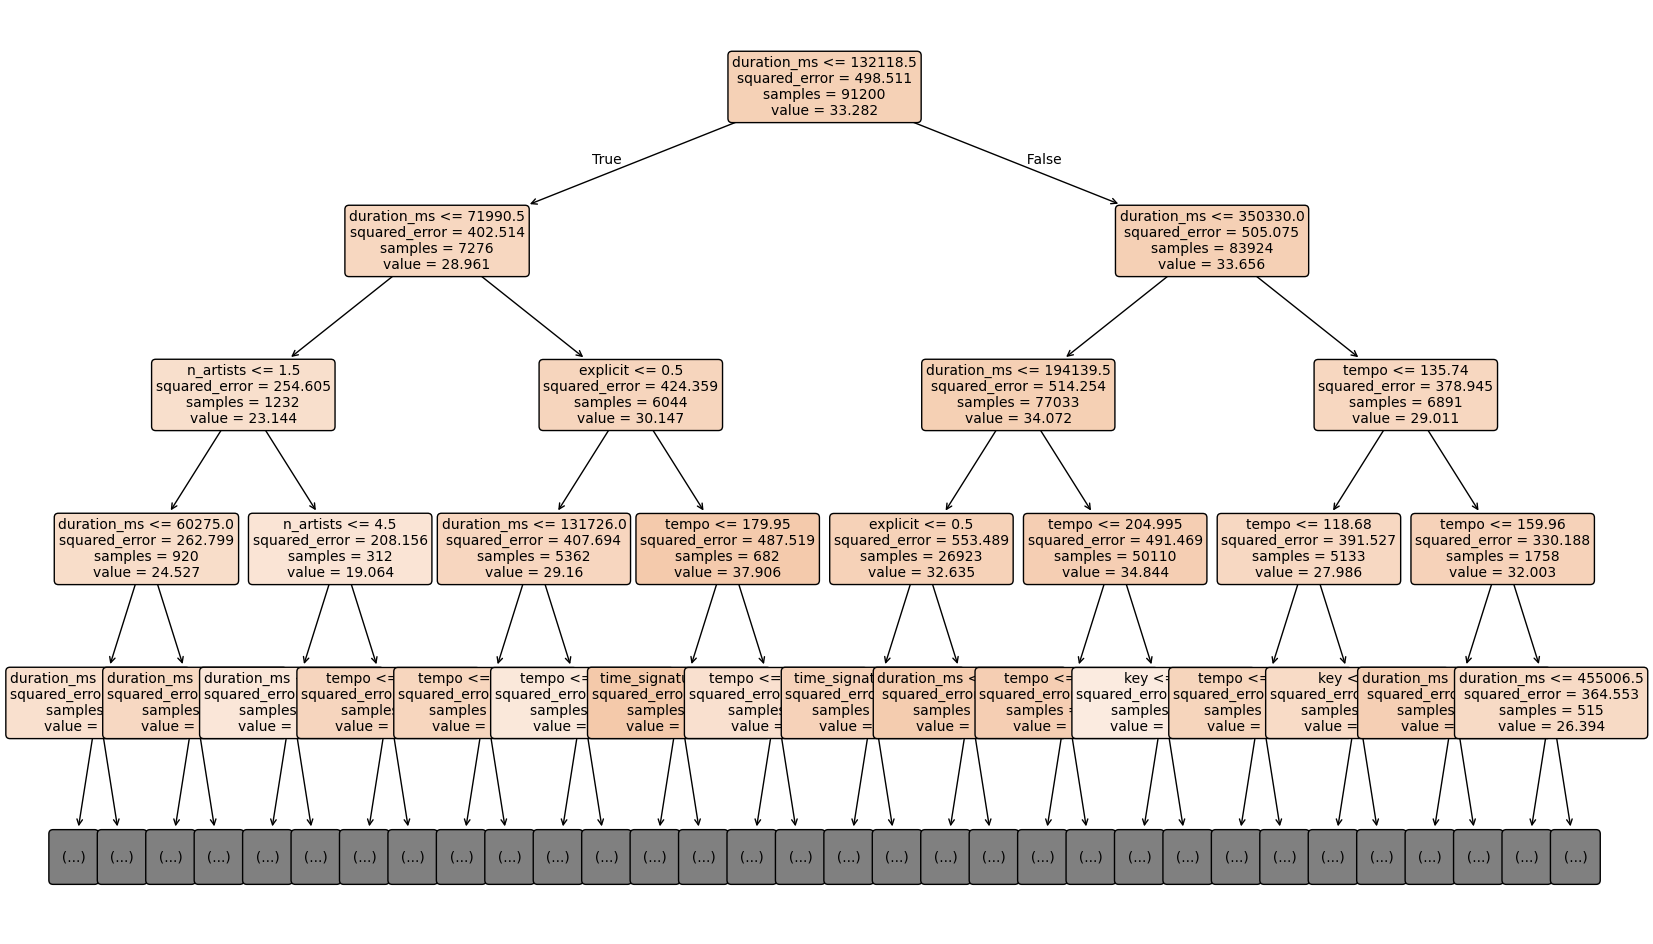

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score

df = pd.read_csv("dataset.csv")
df["n_artists"] = df["artists"].apply(lambda x: len(str(x).split(';')))
# most songs have one artist, less than a quarter two, very few have more but they exist

features = [
    "n_artists",
    "duration_ms",
    "explicit",
    "key",
    "tempo",
    "time_signature",
]

X = df[features]
y = df["popularity"]

numeric_features = ["n_artists", "duration_ms", "explicit", "key", "tempo", "time_signature"]

model = Pipeline(steps=[
    ("tree", DecisionTreeRegressor(
        max_depth=8,     # safe default
        min_samples_split=20,
        random_state=42
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

preds = model.predict(X_test)

print("R²:", r2_score(y_test, preds))
print("RMSE:", root_mean_squared_error(y_test, preds))

tree = model.named_steps["tree"]

all_features = numeric_features

imp = tree.feature_importances_

sorted_features = sorted(zip(imp, all_features), reverse=True)
for importance, name in sorted_features[:20]:
    print(f"{name}: {importance:.4f}")

visualize_decision_tree(model, features, max_depth=4)

We don't gain much from a basic decision tree on track metadata. Next we should try including one-hot genre categories to see if some genres are more important to popularity rating.

R²: 0.09215056249028608
RMSE: 21.166160353606646
track_genre_iranian: 0.1801
track_genre_romance: 0.1700
track_genre_pop-film: 0.1182
track_genre_latin: 0.1128
track_genre_k-pop: 0.0957
track_genre_detroit-techno: 0.0931
track_genre_chicago-house: 0.0865
track_genre_classical: 0.0856
n_artists: 0.0213
duration_ms: 0.0150
explicit: 0.0138
tempo: 0.0069
key: 0.0007
time_signature: 0.0004
track_genre_world-music: 0.0000
track_genre_turkish: 0.0000
track_genre_trip-hop: 0.0000
track_genre_trance: 0.0000
track_genre_techno: 0.0000
track_genre_tango: 0.0000


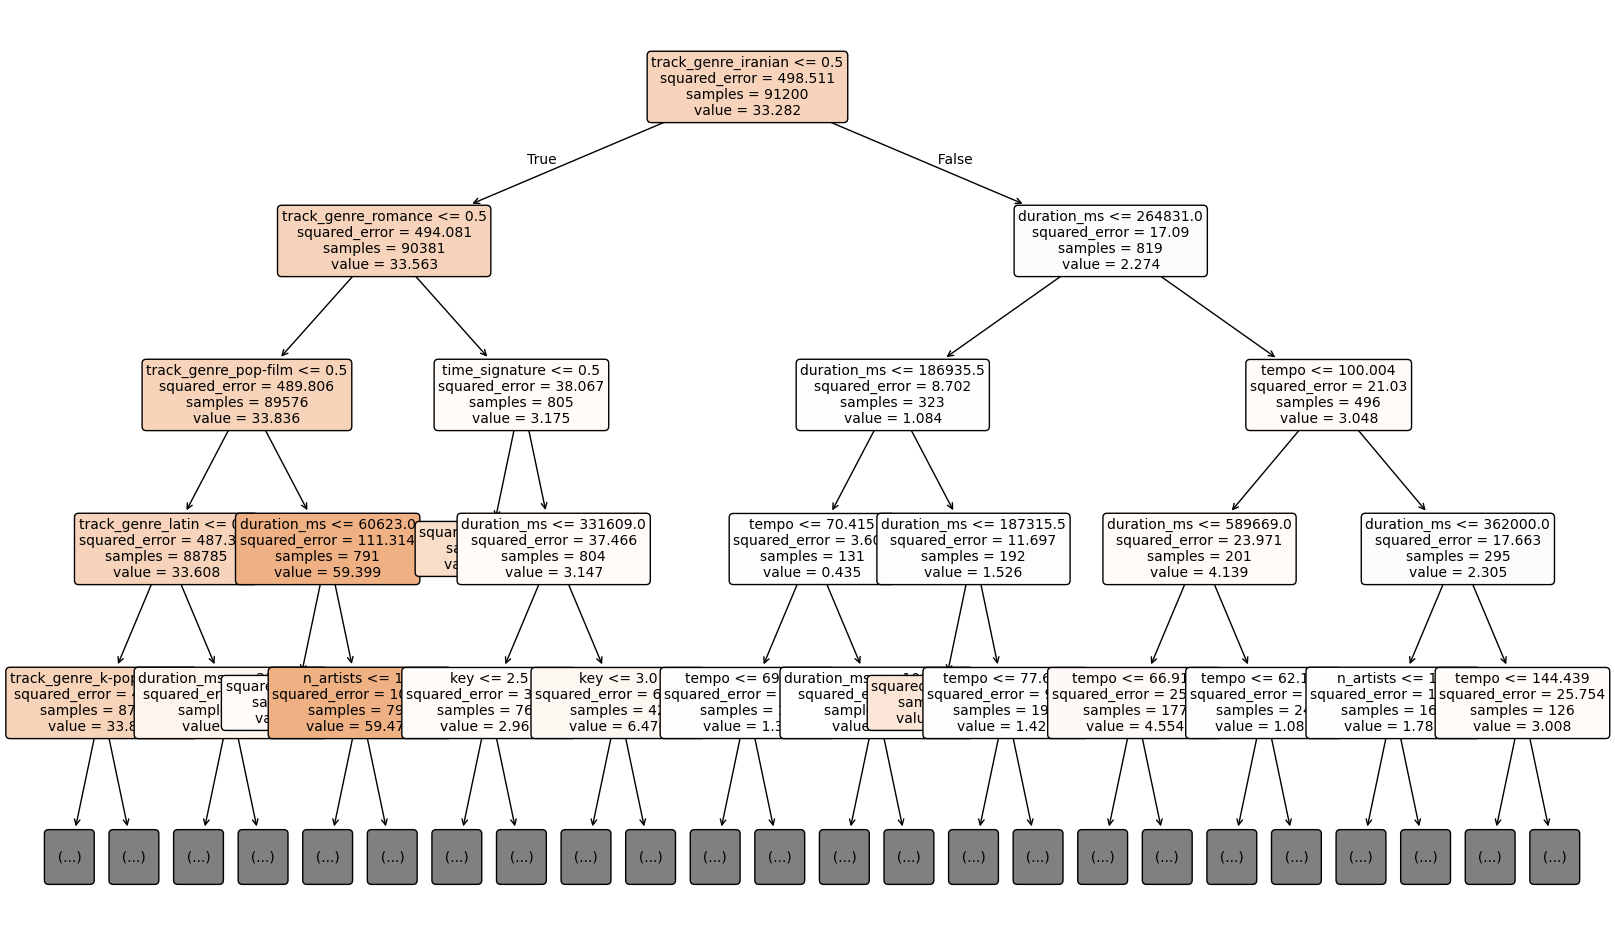

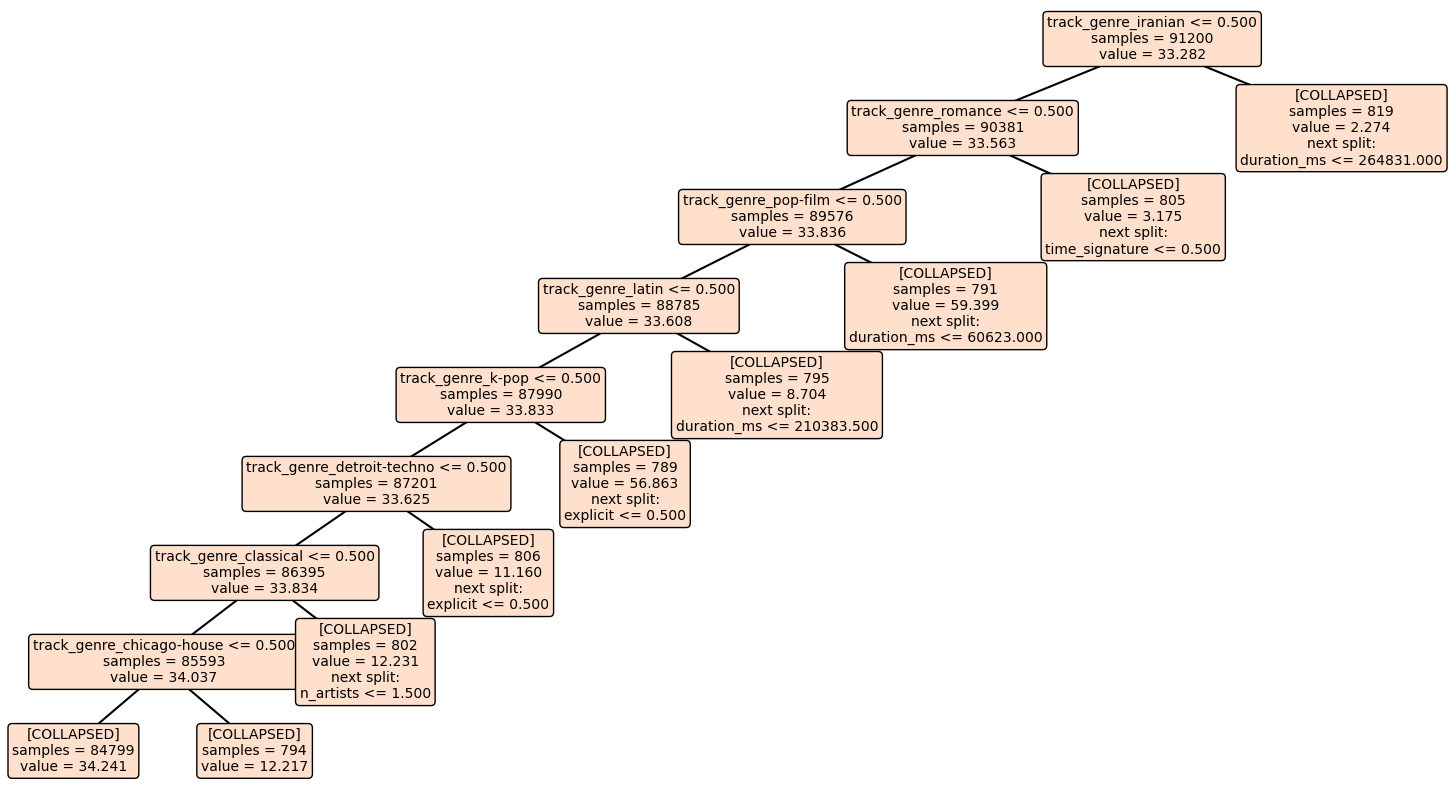

In [ ]:
features = [
    "n_artists",
    "duration_ms",
    "explicit",
    "key",
    "tempo",
    "time_signature",
    "track_genre"
]

X = df[features]
y = df["popularity"]

numeric_features = ["n_artists", "duration_ms", "explicit", "key", "tempo", "time_signature"]
categorical_features = ["track_genre"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("tree", DecisionTreeRegressor(
        max_depth=8,     # safe default
        min_samples_split=20,
        random_state=42
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

preds = model.predict(X_test)

print("R²:", r2_score(y_test, preds))
print("RMSE:", root_mean_squared_error(y_test, preds))

tree = model.named_steps["tree"]
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
genre_features = ohe.get_feature_names_out(["track_genre"])

all_features = numeric_features
all_features = list(genre_features) + numeric_features

imp = tree.feature_importances_

sorted_features = sorted(zip(imp, all_features), reverse=True)
for importance, name in sorted_features[:20]:
    print(f"{name}: {importance:.4f}")

visualize_decision_tree(model, features, max_depth=4)
plot_condensed_tree(model, features, max_depth=8)

Both models end up being poor predictors of popularity, but when we include one-hot genres many of them become major predictors. Next we want to try looking at genres separately to see if any patterns emerge that could better predict a track's popularity within each genre.\
I would also like to note we see 'pop' genres with on-average higher popularity. This makes sense, pop is just an abbreviation for popular music and popularity ranking is done mostly by number of listens weighted by recent listens. 

In [5]:
df['track_genre'].value_counts()

track_genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: count, Length: 114, dtype: int64


=== Genre: sleep | R² = 0.5357 ===



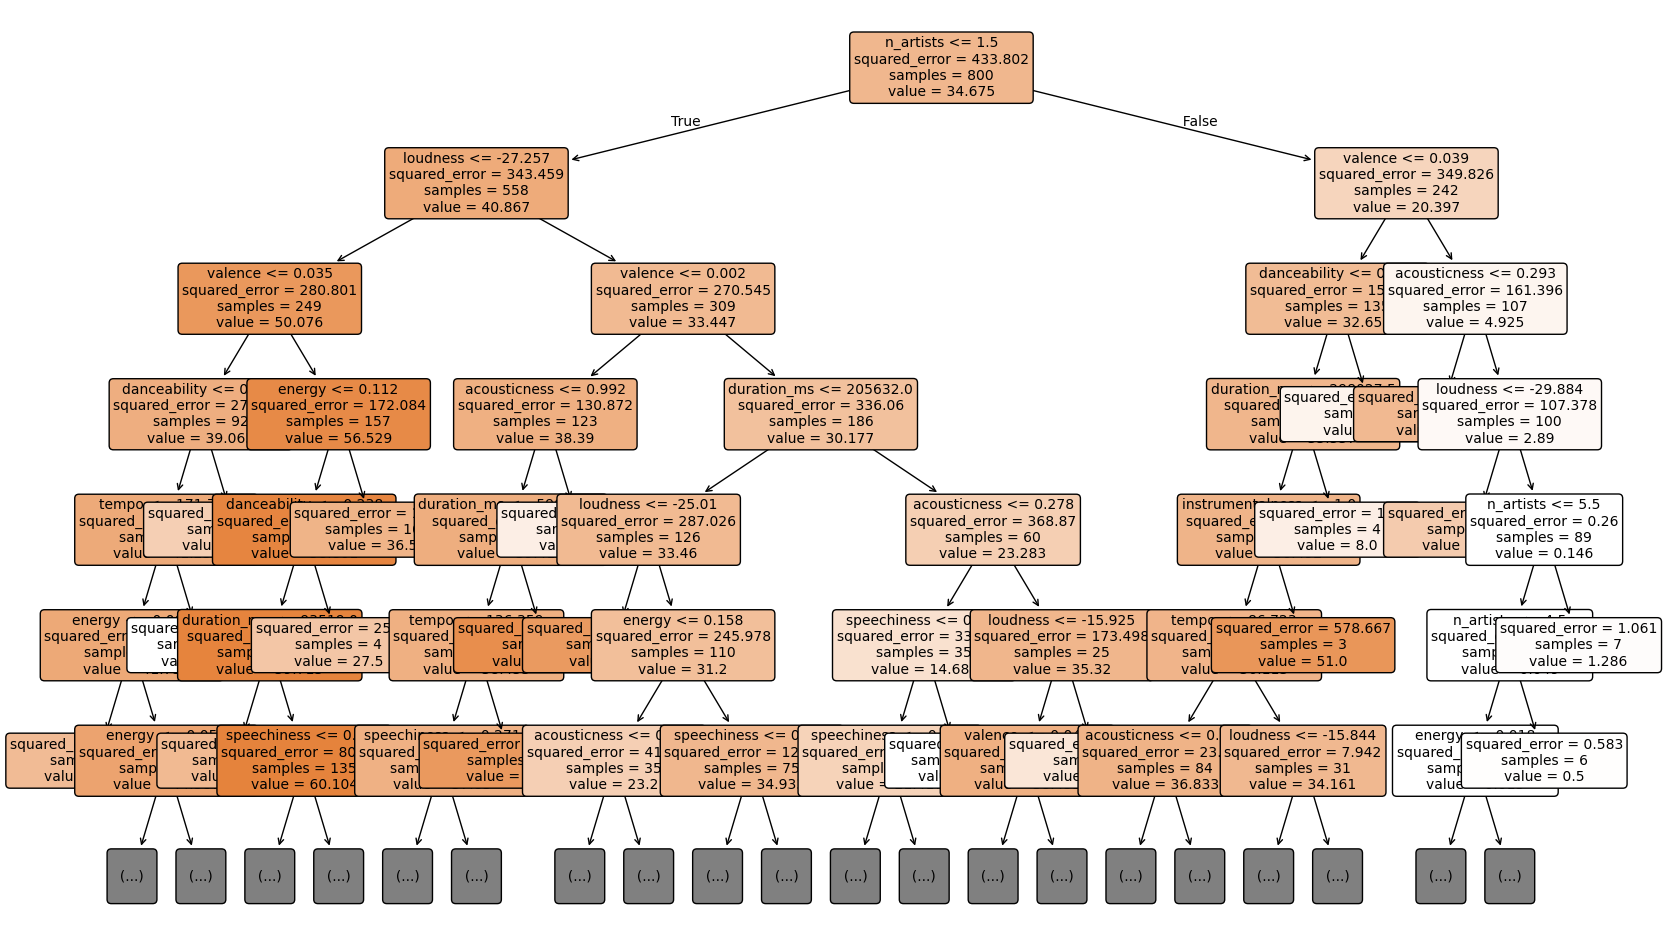


=== Genre: classical | R² = 0.4143 ===



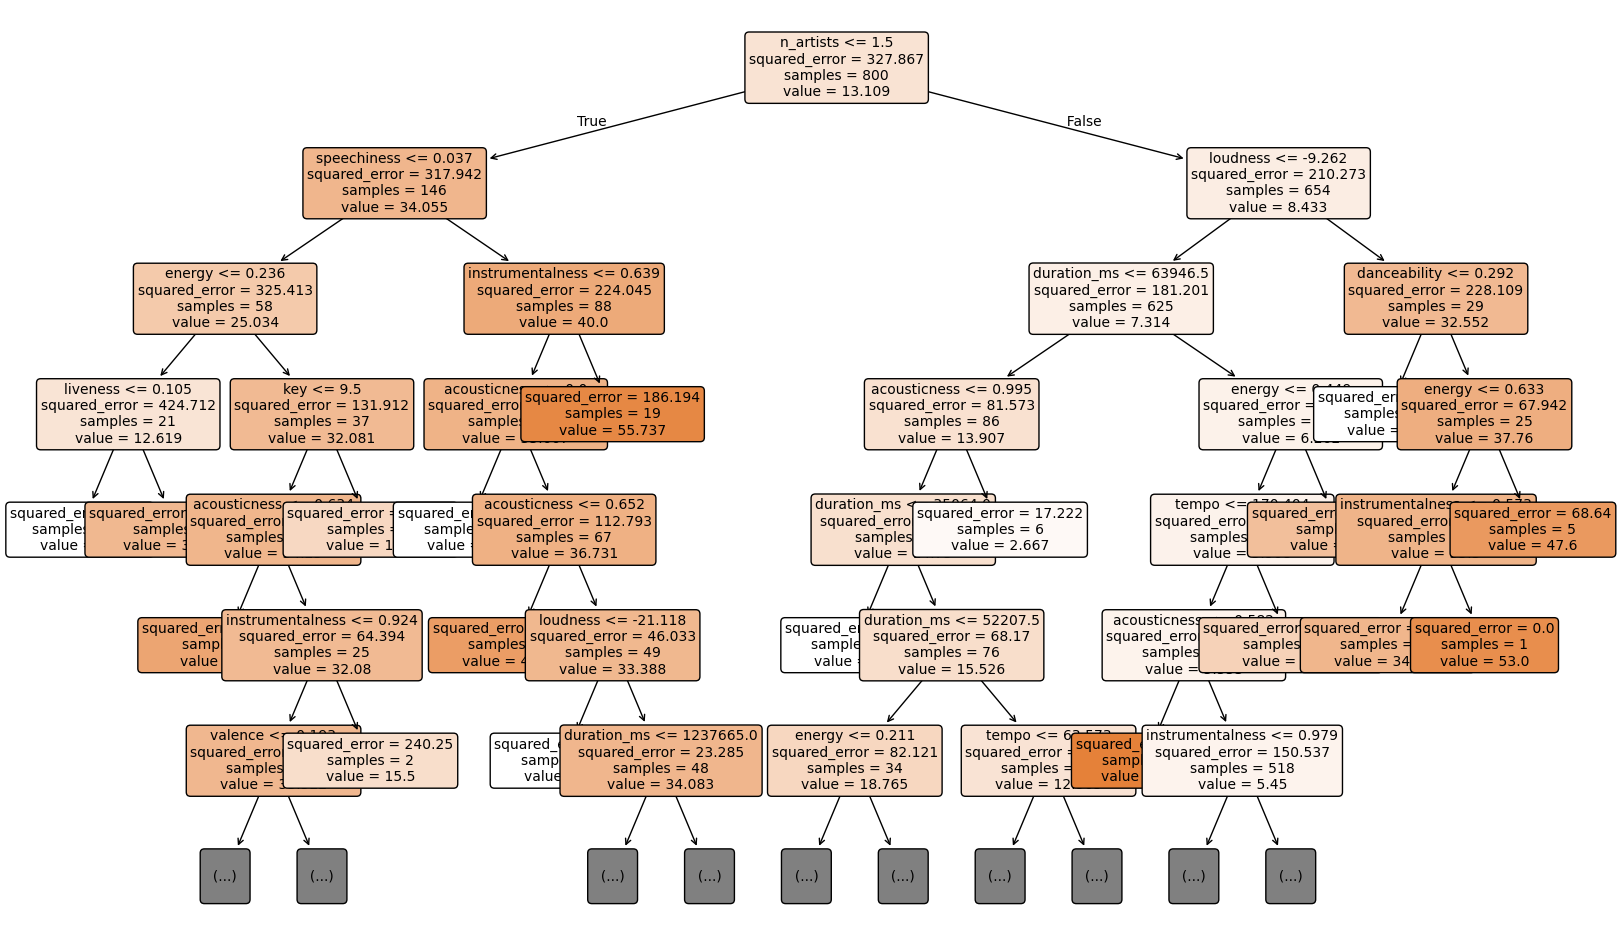


=== Genre: j-pop | R² = 0.2852 ===



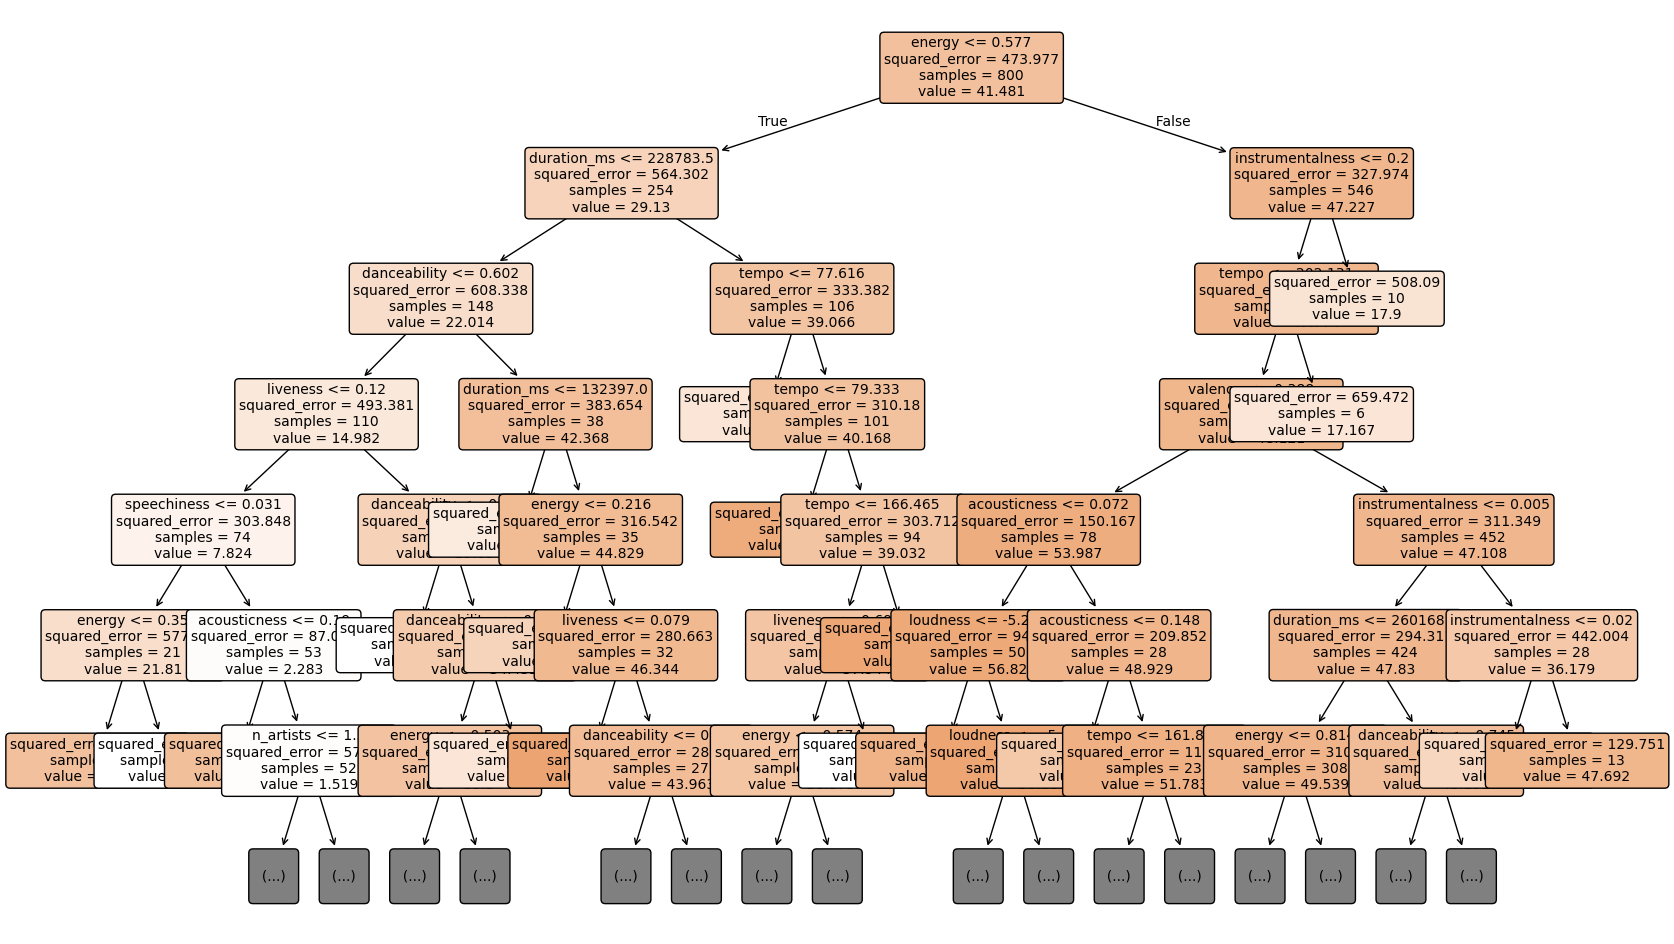

Saved results to genre_tree_results.csv


In [6]:
from sklearn.preprocessing import OrdinalEncoder

features = [
    "n_artists", "duration_ms", "explicit", "key", "tempo",
    "valence", "danceability", "energy", "loudness",
    "speechiness", "acousticness", "instrumentalness", "liveness"
]

results = []  # will hold dicts

all_genres = sorted(df["track_genre"].unique())

for genre in all_genres:
    sub = df[df["track_genre"] == genre]

    # Need enough rows
    if len(sub) < 200:   # adjustable threshold
        continue

    X = sub[features]
    y = sub["popularity"]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train tree
    model = DecisionTreeRegressor(
        max_depth=8,
        min_samples_split=20,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Score
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)

    # Store results
    results.append({
        "genre": genre,
        "model": model,
        "score": r2,
        **{f"imp_{f}": imp for f, imp in zip(features, model.feature_importances_)}
    })

results_sorted = sorted(results, key=lambda d: d["score"], reverse=True)

top3 = results_sorted[:3]

for entry in top3:
    print(f"\n=== Genre: {entry['genre']} | R² = {entry['score']:.4f} ===\n")
    visualize_decision_tree(entry["model"], features, max_depth=6)

df_out = pd.DataFrame(results_sorted)
df_out.to_csv("genre_tree_results.csv", index=False)

print("Saved results to genre_tree_results.csv")


After building separate trees for each genre (and adding track metadata as features) we see a few trees that do a fair job representing the data.\
Sleep music was the easiest to explain, the popular songs in this genre are very quiet, low valence, low energy which is well-represented by our data.\
Our next best tree was for classical music. This tree separates songs with low energy, quiet, and more instrumentals (and less speech) than other genres.\
Our third best tree is J-Pop, at this point our tree loses most of its ability to explain the data. Though our r^2 score is a bit lacking, our first few splits are still great separators. First we see that most of our data isn't exceptionally high energy, high valence, and low instrumentalness. Popular songs tend to be higher tempo, positive songs with less focus on instrumentals\
Popularity, along with other trends, seem easier to track when we separate by genre.


## Graphing

We can make a graph connecting artists that have collaborated on the same album.

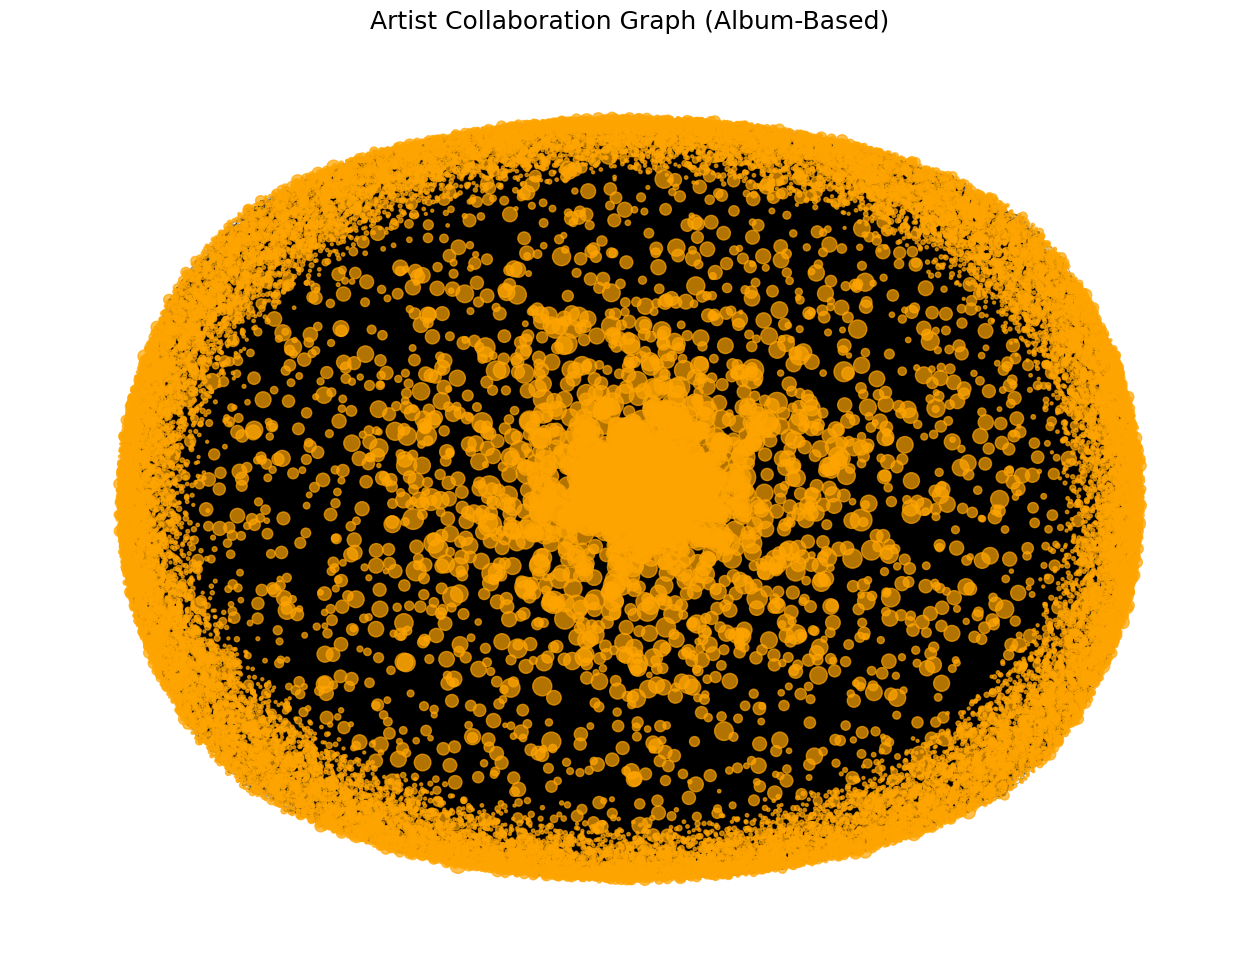

In [15]:
import itertools
import networkx as nx

df["artist_list"] = df["artists"].apply(lambda s: [a.strip() for a in str(s).split(";")])

G = nx.Graph()

for album, group in df.groupby("album_name"):
    # union of artists across all tracks in album
    artists = set()
    for lst in group["artist_list"]:
        artists.update(lst)
    
    # connect all pairs of artists within this album
    for a, b in itertools.combinations(sorted(artists), 2):
        if G.has_edge(a, b):
            G[a][b]["weight"] += 1   # increment collaboration count
        else:
            G.add_edge(a, b, weight=1, album=album)


plt.figure(figsize=(16, 12))

pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Node sizes reflect degree
node_sizes = [3 + 1.5 * G.degree(n) for n in G.nodes()]

# Edge thickness represents collab weight
edge_widths = [0.5 * G[u][v]["weight"] for u, v in G.edges()]

# def sanitize_label(name):
    # return name.replace("$", r"\$")
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="orange", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)
# labels = {n: sanitize_label(n) for n in G.nodes()}
# nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

plt.title("Artist Collaboration Graph (Album-Based)", fontsize=18)
plt.axis("off")
# plt.rcParams['text.usetex'] = False
# plt.rcParams['mathtext.default'] = 'regular'
plt.show()


In [9]:
num_components = nx.number_connected_components(G)
print("Number of connected components:", num_components)

components = list(nx.connected_components(G))
components_sorted = sorted(components, key=len, reverse=True)

for i, comp in enumerate(components_sorted[:4], 1):  # print top 4 largest
    print(f"Component {i}: {len(comp)} artists")
print(f". . .")

largest = max(nx.connected_components(G), key=len)
print("Largest component size:", len(largest))

# k = nx.node_connectivity(G.subgraph(largest))
# print("Node connectivity of largest component:", k)

degrees = dict(G.degree())
avg_degree = sum(degrees.values()) / len(degrees)
print("Average node degree:", avg_degree)


Number of connected components: 1722
Component 1: 17163 artists
Component 2: 26 artists
Component 3: 21 artists
Component 4: 18 artists
. . .
Largest component size: 17163
Average node degree: 13.871414351642386


In [14]:
# 1) PageRank on the artist collaboration graph
pagerank_scores = nx.pagerank(G, alpha=0.85, max_iter=20)

pr_df = (
    pd.DataFrame.from_dict(pagerank_scores, orient="index", columns=["pagerank"])
      .reset_index()
      .rename(columns={"index": "artist"})
)

# 2) Build per-artist metadata from df
#    - explode artist_list so each row is (track, single artist)
artist_meta = (
    df.explode("artist_list")
      .rename(columns={"artist_list": "artist"})
      .groupby("artist", as_index=False)
      .agg(
          avg_popularity=("popularity", "mean"),
          max_popularity=("popularity", "max"),
          track_count=("track_name", "nunique"),
          album_count=("album_name", "nunique"),
      )
)

# (Optional) If your df has a genre column, grab the most common genre per artist
genre_col = None
for col in ["track_genre", "genre", "genres"]:
    if col in df.columns:
        genre_col = col
        break

if genre_col is not None:
    artist_genre = (
        df.explode("artist_list")
          .rename(columns={"artist_list": "artist"})
          .groupby("artist")[genre_col]
          .agg(lambda s: s.value_counts().index[0])  # most frequent genre
          .reset_index()
          .rename(columns={genre_col: "top_genre"})
    )
    artist_meta = artist_meta.merge(artist_genre, on="artist", how="left")

# 3) Merge PageRank with metadata
artist_pr_meta = (
    pr_df.merge(artist_meta, on="artist", how="left")
         .sort_values("pagerank", ascending=False)
         .reset_index(drop=True)
)

# 4) Inspect top PageRank artists with popularity
artist_pr_meta.head(25)


,artist,pagerank,avg_popularity,max_popularity,track_count,album_count,top_genre
0,Arijit Singh,0.001208,59.295082,88,245,184,pop-film
1,Justin Bieber,0.001105,22.182353,89,48,106,pop
2,Pritam,0.001080,53.771772,88,313,138,indian
3,David Guetta,0.000889,20.292000,98,62,79,edm
4,Shreya Ghoshal,0.000850,57.376000,74,91,88,pop-film
5,J Balvin,0.000838,17.588235,88,78,88,reggaeton
6,OneRepublic,0.000781,33.029268,96,71,78,piano
7,Ella Fitzgerald,0.000754,3.365019,67,31,77,blues
8,Stevie Wonder,0.000723,1.715481,75,18,61,funk
9,Katy Perry,0.000720,22.341772,80,20,51,dance


In [19]:
import random
from collections import Counter

def random_walk(G, start_node, walk_length=16):
    walk = [start_node]
    current = start_node
    
    for _ in range(walk_length - 1):
        neighbors = list(G.neighbors(current))
        if not neighbors:
            break
        current = random.choice(neighbors)
        walk.append(current)
        
    return walk

def generate_random_walks(G, num_walks=5000, walk_length=16, seed=42):
    random.seed(seed)
    nodes = list(G.nodes())
    walks = []
    
    for _ in range(num_walks):
        start = random.choice(nodes)
        walks.append(random_walk(G, start, walk_length))
        
    return walks

# Run once and reuse
artist_walks = generate_random_walks(G, num_walks=5000, walk_length=16)
len(artist_walks), artist_walks[0][:10]

def get_seed_baskets(artist_walks, seed_artist, window=5):
    """
    For each random walk containing seed_artist, extract a windowed segment
    around every occurrence of seed_artist and treat it as a basket.
    """
    seed_baskets = []
    
    for walk in artist_walks:
        if seed_artist not in walk:
            continue
        
        indices = [i for i, a in enumerate(walk) if a == seed_artist]
        
        for idx in indices:
            start = max(0, idx - window)
            end = min(len(walk), idx + window + 1)
            segment = walk[start:end]
            
            # Deduplicate but keep order
            seen = set()
            basket = []
            for a in segment:
                if a not in seen:
                    seen.add(a)
                    basket.append(a)
            seed_baskets.append(basket)
    
    return seed_baskets

def frequent_items_from_baskets(baskets, seed_artist=None, top_k=8, min_support=0.01):
    """
    Compute frequent single items from baskets and return top_k items
    sorted by support (fraction of baskets they appear in).
    """
    if not baskets:
        return []
    
    item_counts = Counter()
    num_baskets = len(baskets)
    
    for basket in baskets:
        uniq = set(basket)
        if seed_artist is not None and seed_artist in uniq:
            uniq.remove(seed_artist)
        for item in uniq:
            item_counts[item] += 1
    
    freq_items = []
    for item, count in item_counts.items():
        support = count / num_baskets
        if support >= min_support:
            freq_items.append((item, support, count))
    
    freq_items.sort(key=lambda x: x[1], reverse=True)
    return freq_items[:top_k]

def top_tracks_for_artist(df, artist, n=3):
    """
    Return top n tracks for a given artist, sorted by popularity.
    Assumes df['artist_list'] is a list of artists per track.
    """
    mask = df["artist_list"].apply(lambda lst: artist in lst)
    subset = df.loc[mask].copy()
    
    if subset.empty:
        return pd.DataFrame(columns=["artist", "track_name", "album_name", "popularity"])
    
    subset = (
        subset.assign(artist=artist)
              .sort_values("popularity", ascending=False)
              [["artist", "track_name", "album_name", "popularity"]]
              .drop_duplicates(subset=["track_name", "album_name"])
              .head(n)
    )
    return subset

def build_playlist_for_seed(df, artist_walks, seed_artist,
                            window=5, top_k_items=8,
                            tracks_per_item=3, min_support=0.01):
    # 1) Get local baskets around the seed artist
    baskets = get_seed_baskets(artist_walks, seed_artist, window=window)
    
    # 2) Get top frequent neighboring artists
    top_items = frequent_items_from_baskets(
        baskets,
        seed_artist=seed_artist,
        top_k=top_k_items,
        min_support=min_support
    )
    
    if not top_items:
        print(f"No frequent items found around '{seed_artist}'.")
        return pd.DataFrame()
    
    # 3) Collect tracks for each frequent artist
    playlist_parts = []
    for artist, support, count in top_items:
        tracks = top_tracks_for_artist(df, artist, n=tracks_per_item)
        if not tracks.empty:
            tracks = tracks.assign(
                seed_artist=seed_artist,
                neighbor_support=support,
                neighbor_count=count
            )
            playlist_parts.append(tracks)
    
    if not playlist_parts:
        return pd.DataFrame()
    
    playlist = pd.concat(playlist_parts, ignore_index=True)
    
    # De-duplicate tracks in case they appear under multiple artists
    playlist = playlist.drop_duplicates(subset=["track_name", "album_name"]).reset_index(drop=True)
    
    return playlist

# build playlist for a seed artist
playlist = build_playlist_for_seed(df, artist_walks, seed_artist="Stevie Wonder",
                                   window=5, top_k_items=8, tracks_per_item=3,
                                   min_support=0.01)

playlist.head(30)


,artist,track_name,album_name,popularity,seed_artist,neighbor_support,neighbor_count
0,Four Tops,"I Can't Help Myself (Sugar Pie, Honey Bunch)",Four Tops Second Album,73,Stevie Wonder,0.117647,4
1,Four Tops,Reach Out I'll Be There - Single Version / Mono,Fiesta temática 60s,1,Stevie Wonder,0.117647,4
2,Four Tops,Keeper Of The Castle,On air 70's Hits,1,Stevie Wonder,0.117647,4
3,The Runaways,Cherry Bomb,The Runaways,69,Stevie Wonder,0.117647,4
4,The Runaways,Cherry Bomb,On air 70's Hits,0,Stevie Wonder,0.117647,4
5,Florence + The Machine,Never Let Me Go,Ceremonials (Original Deluxe Version),66,Stevie Wonder,0.117647,4
6,Florence + The Machine,Stand By Me,Sad Covers 2022,3,Stevie Wonder,0.117647,4
7,Florence + The Machine,Seven Devils,Helloween Party,2,Stevie Wonder,0.117647,4
8,Nat King Cole,L-O-V-E,L-O-V-E,71,Stevie Wonder,0.088235,3
9,Nat King Cole,Unforgettable,Unforgettable,67,Stevie Wonder,0.088235,3
